 # Experiments with EcoNets
 
 ## Overview
 
 This notebook contains the experiments we are doing trying to construct ecologically inspired machine learning models. In particular, a key feature will be to try to exploit the mapping from MCRM to QP.  We will start with some preliminary coding tests and then load MNIST data. The idea will be to build sparse hashes from the examples and then use KNN classifiers to see how we do. 

## Loading QP libraries and Defining QP function

Here we will experiment with the QP libraries and make sure we know how to use them. We will work with the quadprog package because it seems to be the fastest based on this blog. 

We define a wrapper function quadprog_solve_qp that solves the problem

\begin{align}
\mathrm{minimize} \hspace{2cm} & {1 \over 2} x^T P x +q^T x \\
\mathrm{subject\,to } \hspace{2cm} & Gx \le h \\
& Ax = b\
\end{align}


Notice for the case where we want to minmize 
$ {1 \over 2}|| x- K||^2$, corresponds to $P=I$ and $q=-K$.

Quadprog returns [x, fval, Lambda] for the problem


In [17]:
import quadprog as quadprog
import numpy as np



def quadprog_solve_qp(P, q, G=None, h=None, A=None, b=None):
    qp_G = .5 * (P + P.T)   # make sure P is symmetric
    qp_a = -q
    if A is not None:
        qp_C = -numpy.vstack([A, G]).T
        qp_b = -numpy.hstack([b, h])
        meq = A.shape[0]
    else:  # no equality constraint
        qp_C = -G.T
        qp_b = -h
        meq = 0
    temp=quadprog.solve_qp(qp_G, qp_a, qp_C, qp_b, meq)
    return [temp[0],temp[1],temp[4]]

M = np.array([[1., 2., 0.], [-8., 3., 2.], [0., 1., 1.]])
P = np.dot(M.T, M)
q = np.dot(np.array([3., 2., 3.]), M).reshape((3,))
G = np.array([[1., 2., 1.], [2., 0., 1.], [-1., 2., -1.]])
h = np.array([3., 2.,-2.]).reshape((3,))



temp=quadprog_solve_qp(P, q, G, h)
print(temp)

# Check that indeed last constraint is active but others are not
print(G.dot(temp[0])-h)



[array([-0.49025721, -1.57755261, -0.66484801]), -10.494933749025723, array([0.        , 0.        , 0.47700701])]
[-7.31021044 -3.64536243  0.        ]


# Importing and formating MNIST

We will not import MNIST and play around with some data. The idea will be that the MNIST will be species whose coefficients are given by the pixel values. Importantly, these are all positive. We will import the data from SciKit Learn.


In [18]:
# This function plots images from array starting at N_start and ending at N_stop


def plot_images(X_train, index):
    N=len(index)
    print(N)
    plt.figure(figsize=(30, 15))
    #Number of examples to show rounded to multiple of 4
    
    for i in range(N):
        example_images = plt.subplot(np.ceil(N/4), 4, i+1)
        example_images.matshow(X_train[index[i],:].reshape(28, 28), cmap='gray')
        example_images.set_xticks(())
        example_images.set_yticks(())
    plt.show()
    return

40


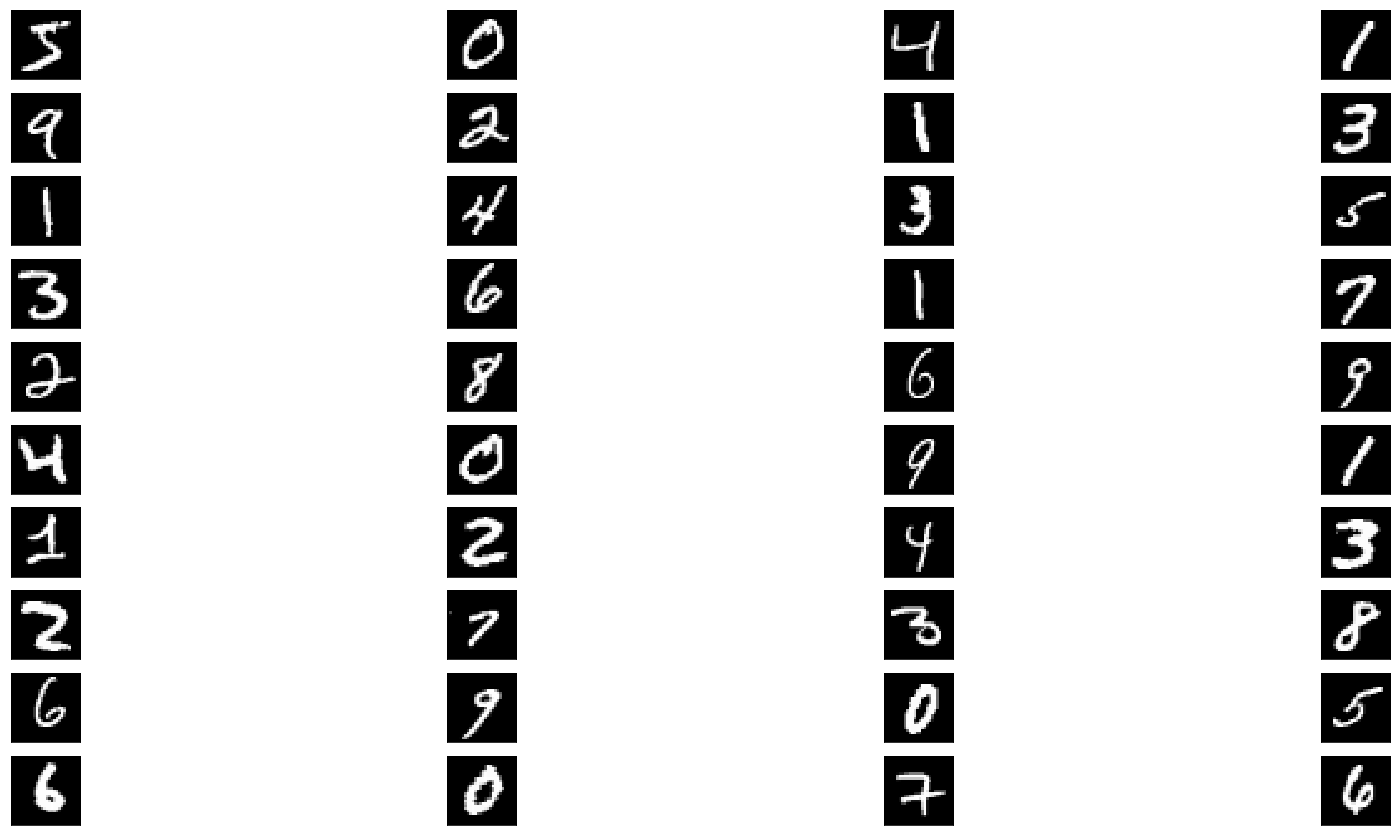

In [19]:
from keras.datasets import mnist
import matplotlib.pyplot as plt
import math


# input image dimensions
num_classes = 10 # 10 digits

img_rows, img_cols = 28, 28 # number of pixels 


(X_train, Y_train), (X_test, Y_test) = mnist.load_data()
# reshape data, depending on Keras backend
X_train = X_train.reshape(X_train.shape[0], img_rows*img_cols)
X_test = X_test.reshape(X_test.shape[0], img_rows*img_cols)
    

# cast floats to single precesion
#X_train = X_train.astype('float32')
#X_test = X_test.astype('float32')

# rescale data in interval [0,1]
X_train = X_train/ 255
X_test = X_test/255

plot_images(X_train, np.arange(0,40))


## MNIST Hashes using QP

We will now exploit the relationship between QP and MCRM to create sparse, decorrelated hashes. The idea will be to 
have each image be a "consumer"that eats resources. Right now we will use the resource dimension as the size of the image.

We output the hashed images and look at how well we can sparsify. To do so, we create a function that produces the hash using QP and outputs the usual stuff. We also can visualize the hashes using the functions above.


In [20]:
# This function will create a hash out of things taking input the Consumer_Matrix,
# an optional index of consumers to hash, and an optional index to use in the hash

def create_hash(Consumer_Matrix, K=None, index=None):
    
    M=Consumer_Matrix.shape[1]
    
    #Define N as length of index if none use all enteries
    if index is None:
        index=np.arange(Consumer_Matrix.shape[0])
    N=len(index)
    
    
    if K is None:
        K=np.random.normal(1, 0, M)
    
    if len(K)!= M:
         print("Your consumer matrix and resource vector do not match")
         return -1
    
    C=Consumer_Matrix[index,:]
    m=np.ones(N)
    #Create matrix to enforce positivity for all constraints
    G=np.vstack((C, -1*np.identity(M)))

    #Create ineqaulity matrix

    h=np.concatenate((m, np.zeros(M)))
    
    #Call quadratic programming routine

    [R_out, f_out, lambda_out]=quadprog_solve_qp(np.identity(M), -1*K, G, h)
    hash_index=index[np.where(lambda_out[0:N]>0)]
    return [hash_index, R_out, f_out, lambda_out]


62


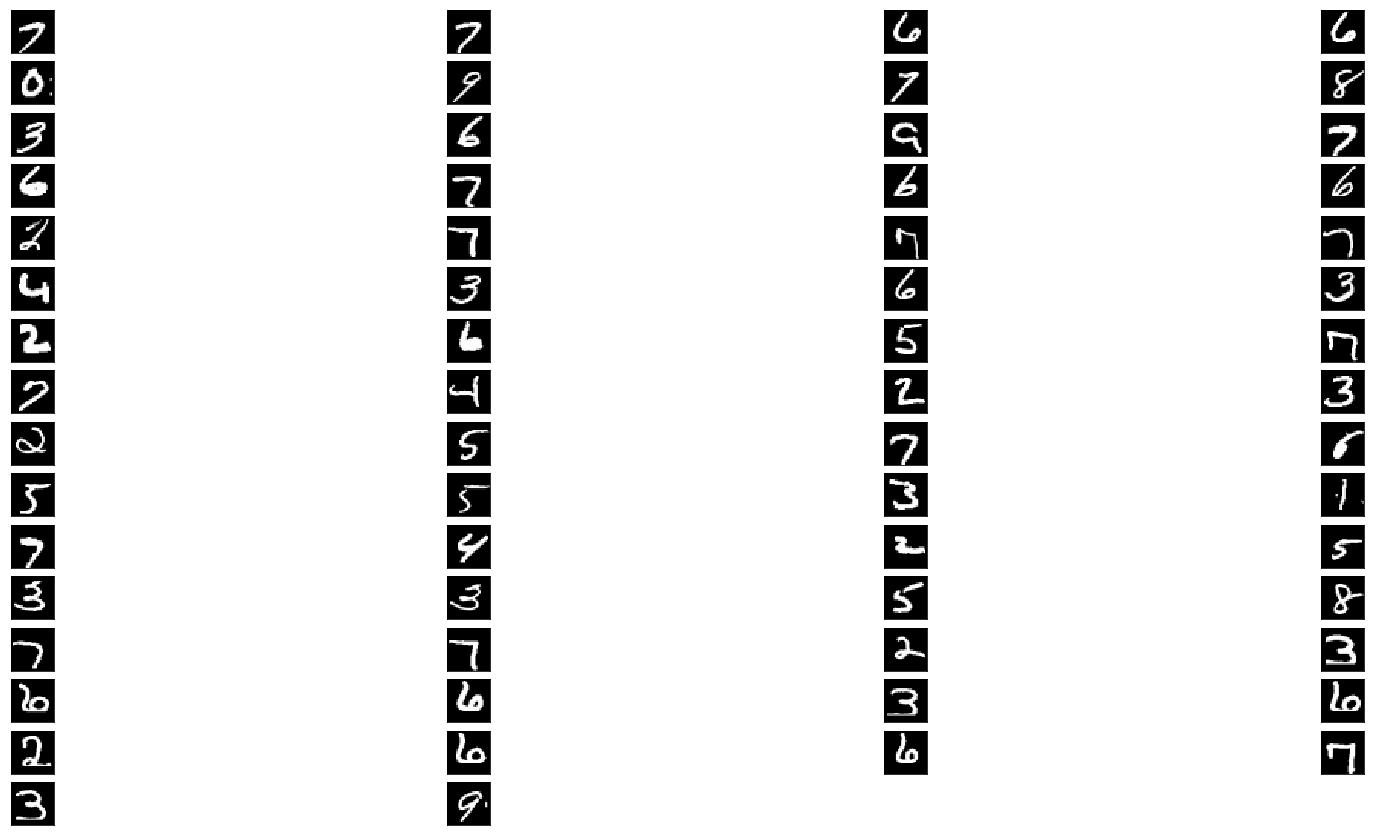

In [21]:

# Number of resources. When resources are pixels this should be size of image

M=img_rows*img_cols 

## Test this function

N_start=0
N=5000
index=np.arange(N_start,N_start+N)
K=np.ones(M)

[hash_indx, R_out, f_out, lambda_out]=create_hash(X_train,K,index)

#Plot hashed images


plot_images(X_train, hash_indx)





One of the most interesting observations is that the number of examples of each number is very uneven.

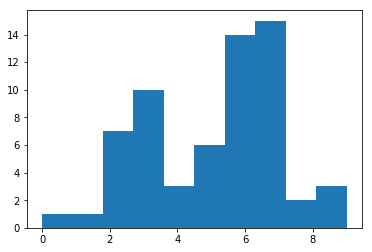

In [22]:
X_hash=X_train[hash_indx,:]
Y_hash=Y_train[hash_indx]

#Plot number of hashes.
plt.hist(Y_hash, bins=10)
plt.show()

## Number of hashed images 

One of the things we would like to do is explore how the number of hashed images depends on the size of training data set and the resource vector $K$ which becomes a hyperparameter. Let us do some quick numerical experiments exploring this below.

In [23]:
## These are numerical experiments exploring effect of K and N on size

Nvector=[10,100, 1000, 10000,60000]
Kvector=[0.01,0.1,1,10,100,1000]

M=img_rows*img_cols 

len(Nvector)
Number_of_hashes=np.zeros((len(Nvector), len(Kvector)))
for i in range(len(Nvector)):
    for j in range(len(Kvector)):
        K=Kvector[j]*np.ones(M)
        index=np.arange(Nvector[i])
        [hash_indx, R_out, f_out, lambda_out]=create_hash(X_train,K,index)
        Number_of_hashes[i,j]=len(hash_indx)

print(Number_of_hashes)


[[ 2.  9.  9.  9.  9.  9.]
 [ 6. 20. 26. 29. 26. 27.]
 [ 6. 21. 53. 52. 49. 50.]
 [ 4. 25. 65. 75. 75. 74.]
 [ 3. 43. 73. 96. 92. 91.]]


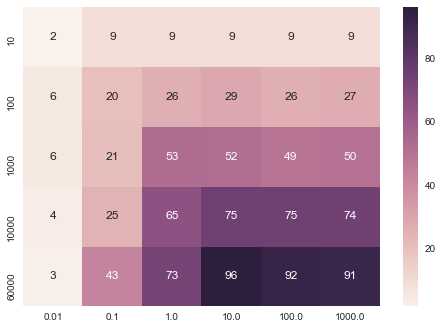

In [24]:
import seaborn as sbn
import pandas as pd

df=pd.DataFrame(data=Number_of_hashes,index=Nvector,columns=Kvector)
sbn.heatmap(df,annot=True)

plt.show()

## Understanding how well we do using K-nearest neighbors


We would like to see if this kind of "Ecological Hashing" really has any meaningful results. One way to do this is exploit the fact that we have supervised labels. For this reason, we can do this with K-NN algorithm. 

Since N=1000 seems to be a good number we can now try to do some experiments. We will start by calculating accuracy using nearest-neighbor on the hashes starting with the test set. We can compare to 91 random images. With such a small dataset N=1 is the best performance.

The accuracy is 0.5583


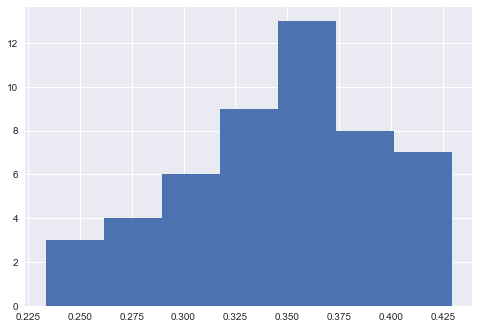

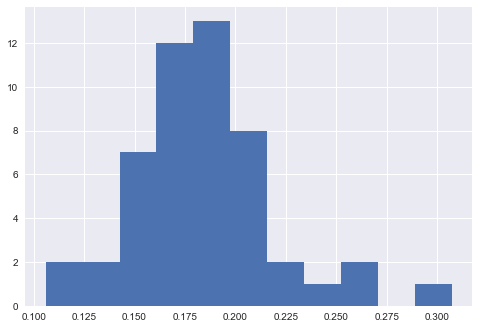

In [25]:
from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier(n_neighbors=1)
neigh.fit(X_hash, Y_hash)
Y_pred=neigh.predict(X_test)
print("The accuracy is" ,sum(Y_pred==Y_test)/len(Y_test))


accuracy_array=np.zeros(50)

for j in range(50):
    rand_index=np.random.randint(len(Y_hash), size=10)
    neigh_rand = KNeighborsClassifier(n_neighbors=1)
    neigh_rand.fit(X_test[rand_index,:], Y_test[rand_index])
    Y_pred_rand=neigh_rand.predict(X_test)
    accuracy_array[j]=sum(Y_pred_rand==Y_test)/len(Y_test)
    
plt.hist(accuracy_array, bins='auto')
plt.show()


for j in range(50):
    rand_index=np.random.randint(len(Y_hash), size=10)
    neigh_rand = KNeighborsClassifier(n_neighbors=5)
    neigh_rand.fit(X_test[rand_index,:], Y_test[rand_index])
    Y_pred_rand=neigh_rand.predict(X_test)
    accuracy_array[j]=sum(Y_pred_rand==Y_test)/len(Y_test)
    
plt.hist(accuracy_array, bins='auto')
plt.show()



This has consistently bettter accuracy 0.53 than random. However, not great. Part of it is that there are not very many example 4s in the data or other things. Perhaps, we should seperately hash each number. For example, here is a histogram of the hashed numbers below there are only a few 8,4, or 9.

## Making seperate hashes for each number

We now experiment with making seperate hashes with each number 

61


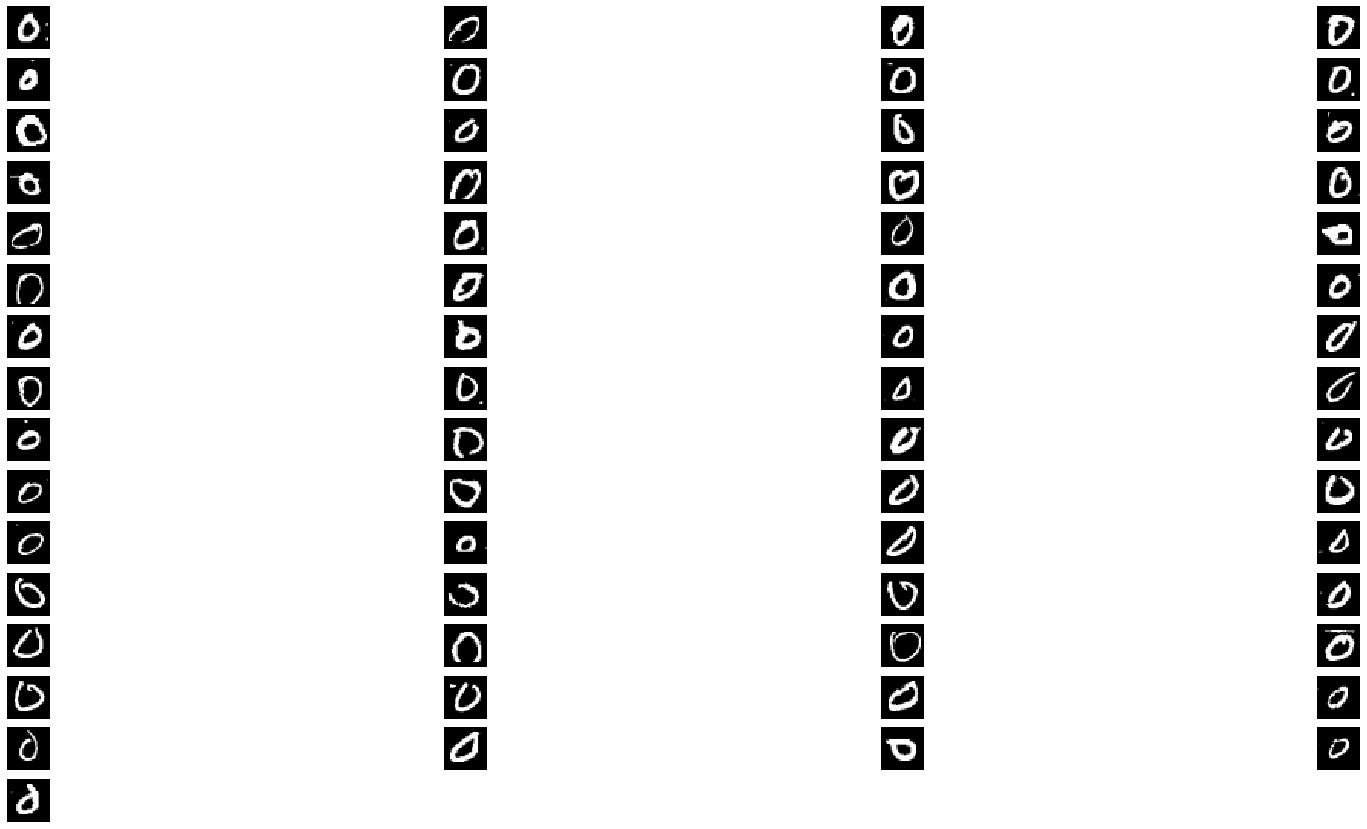

81


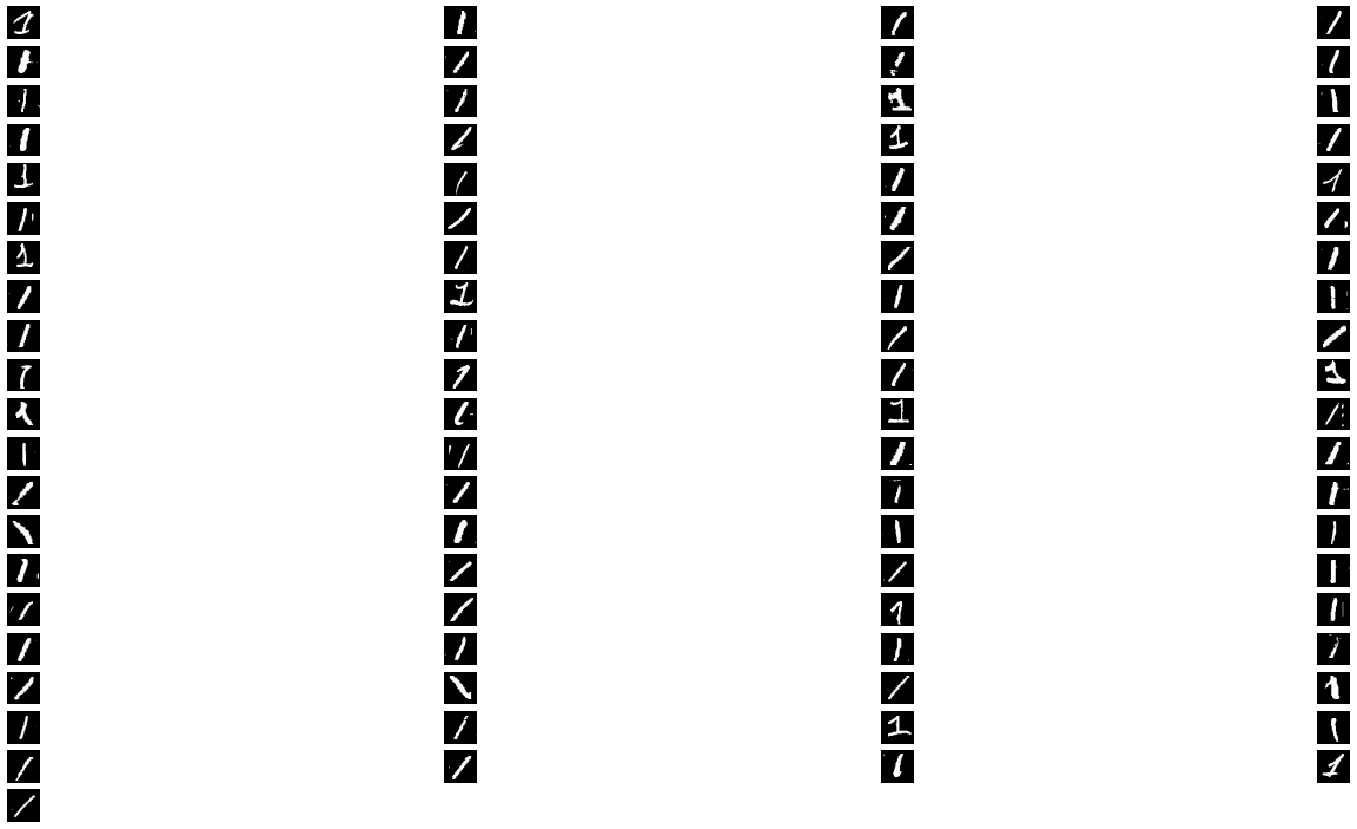

52


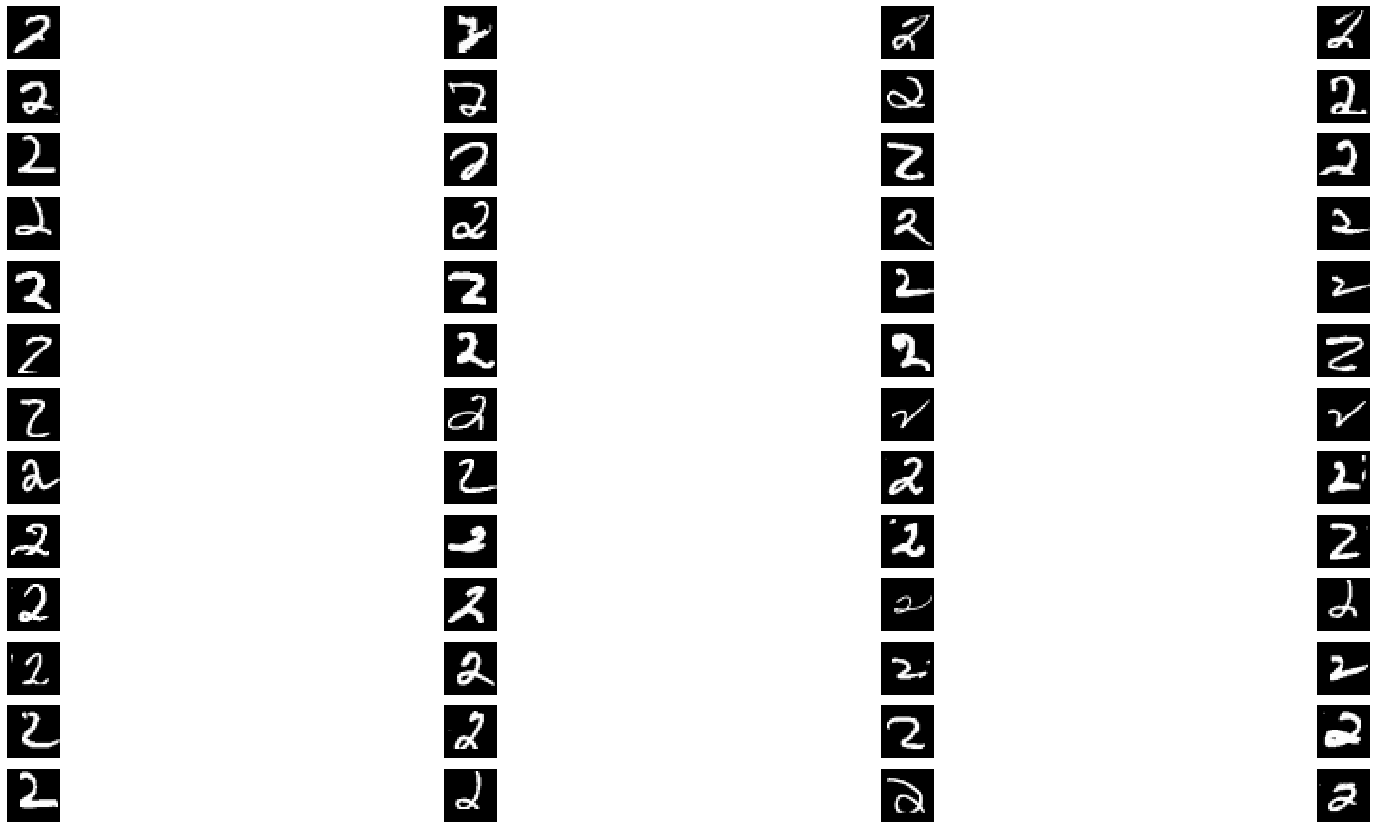

45


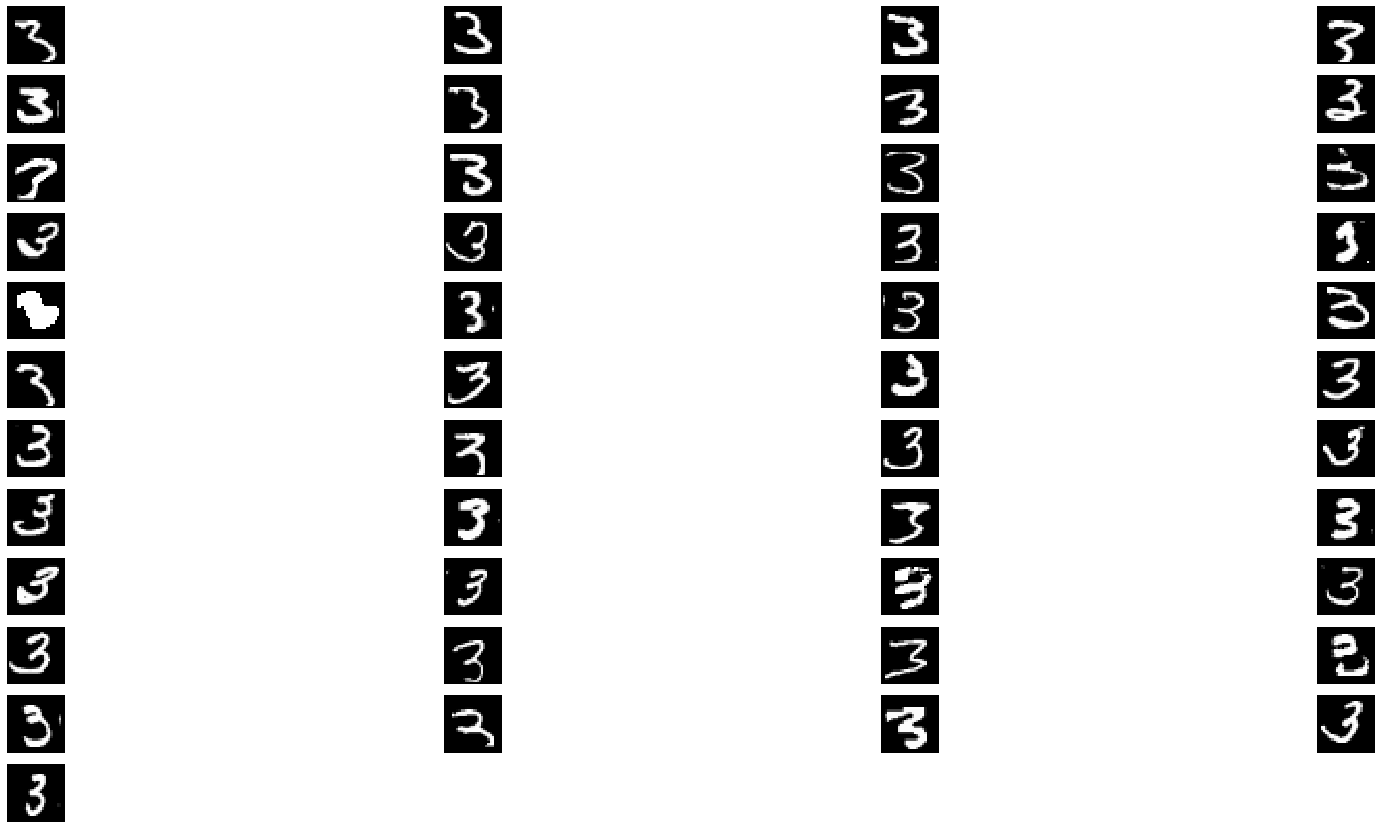

56


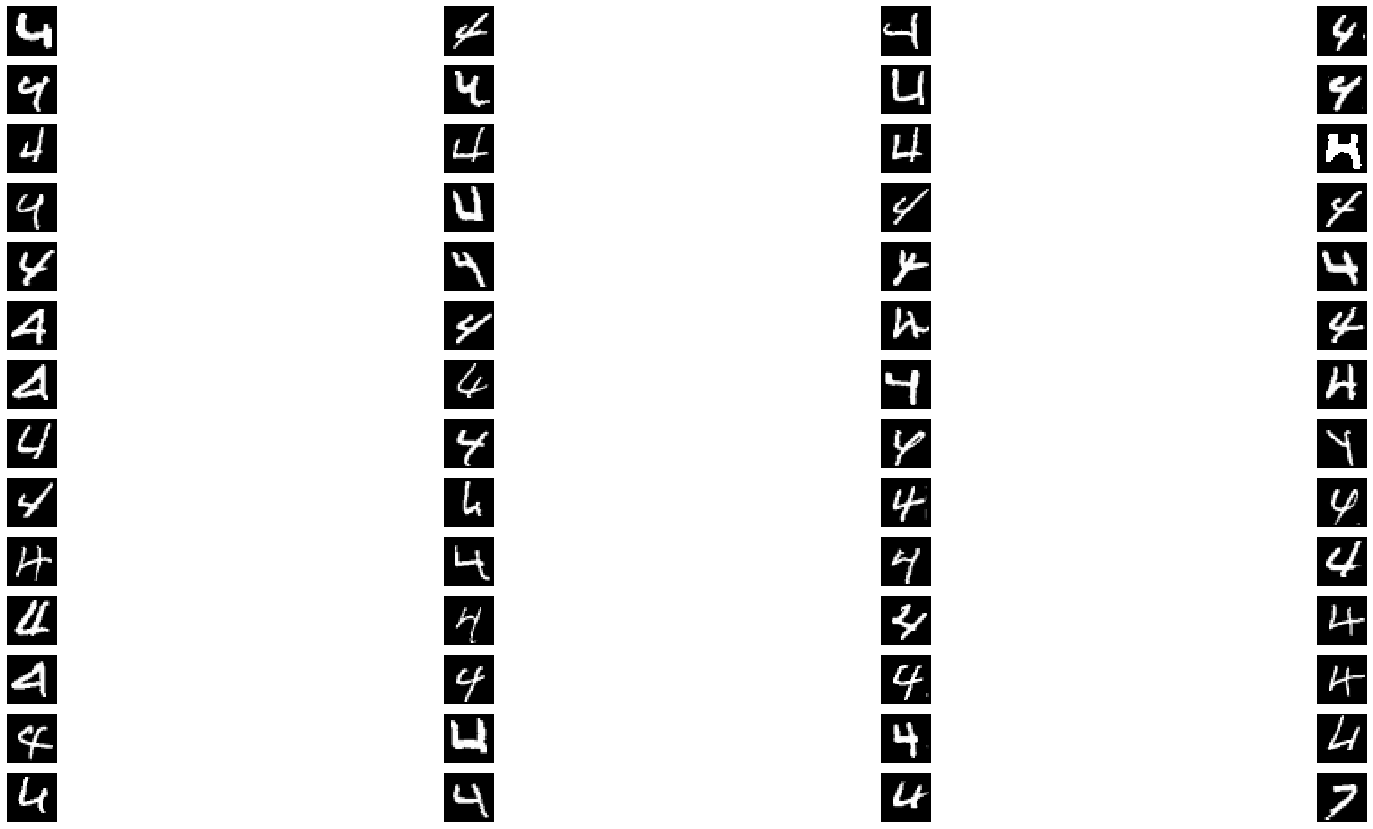

46


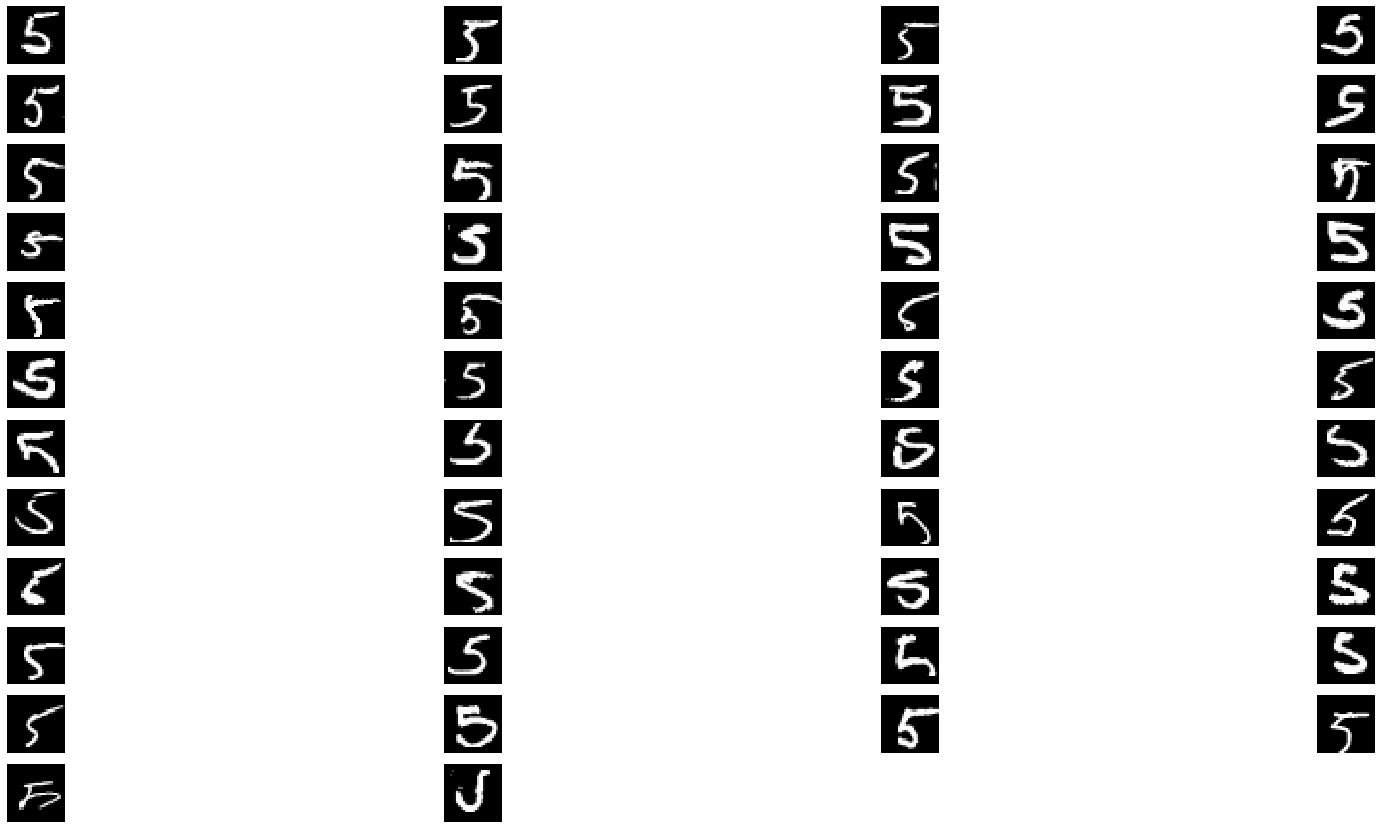

53


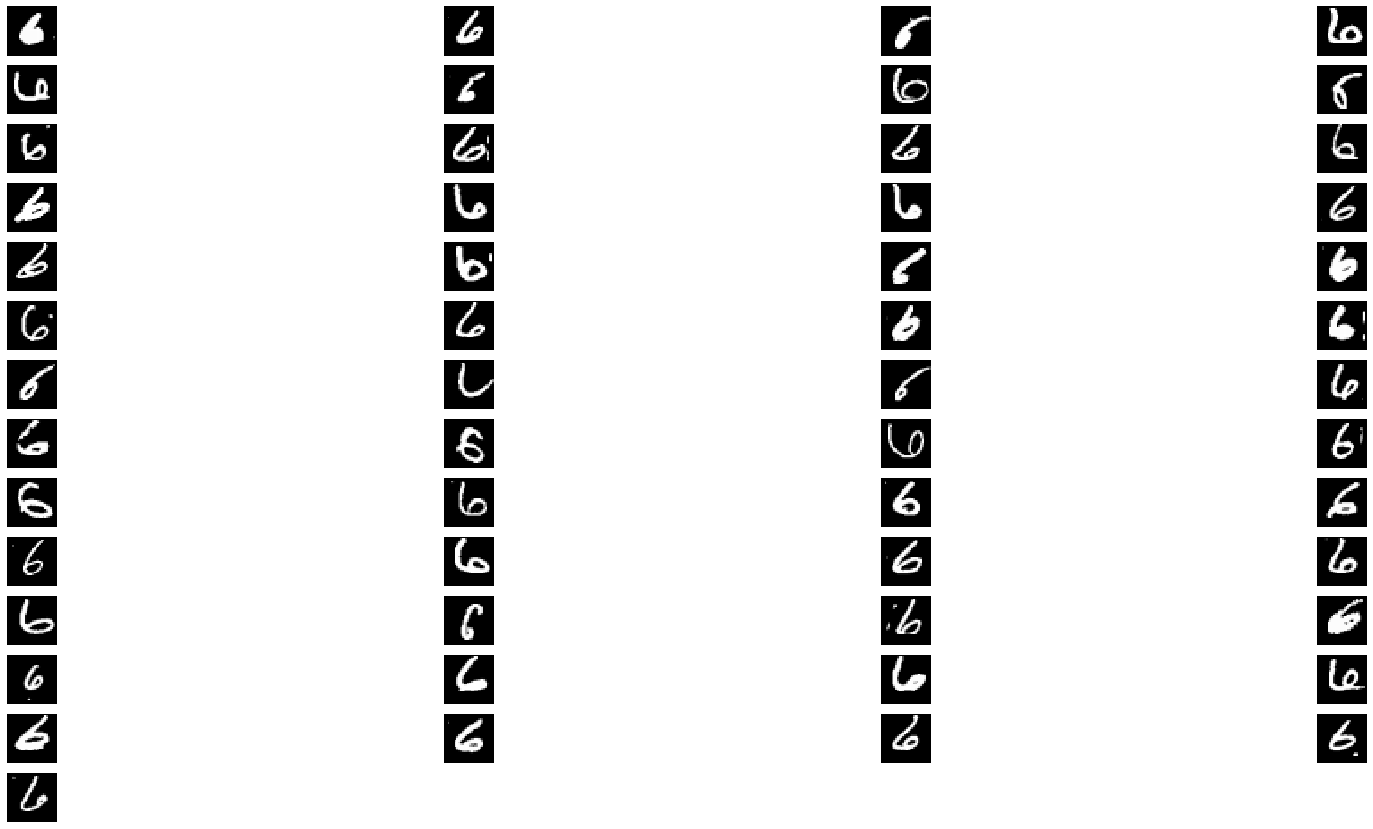

67


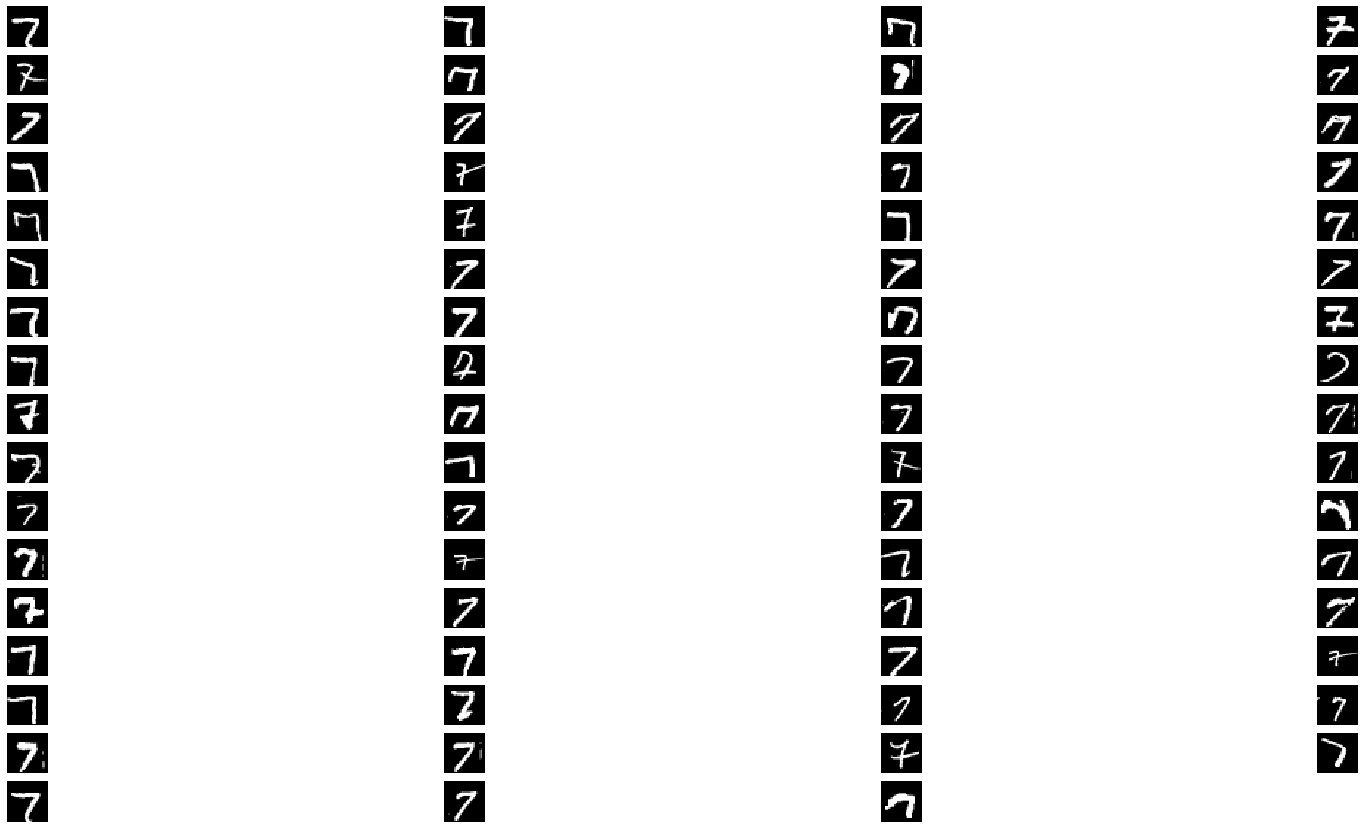

45


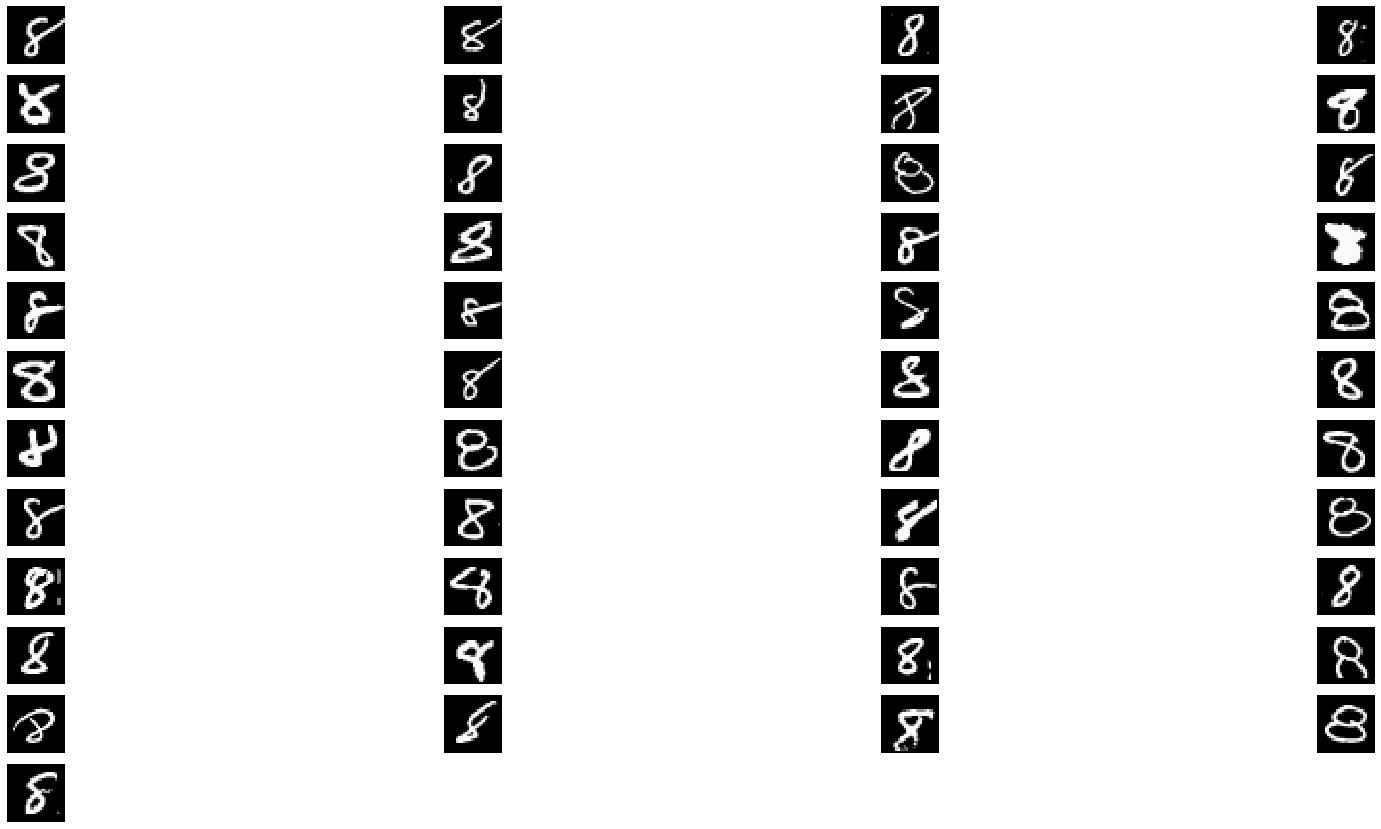

44


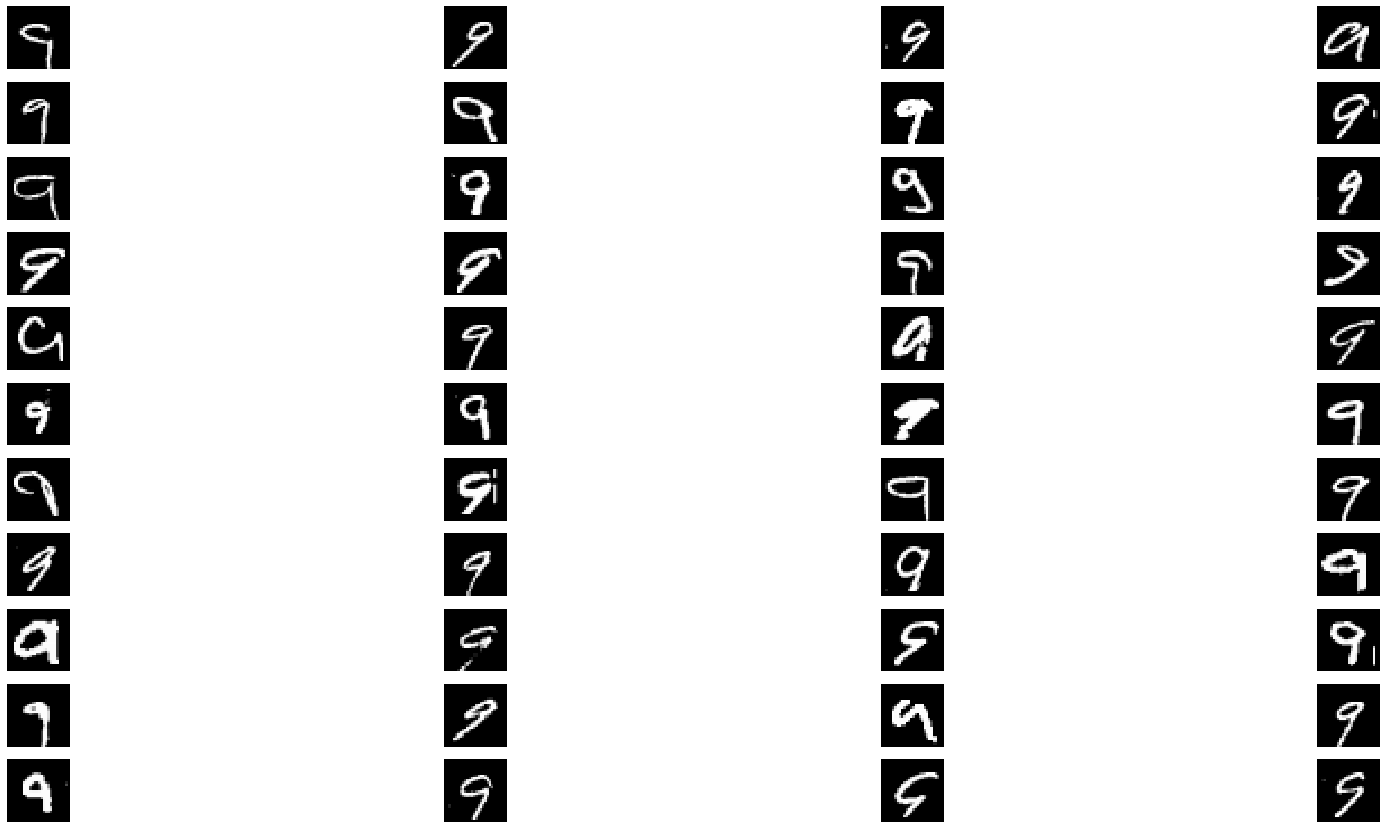

In [26]:
# Number of resources. When resources are pixels this should be size of image

#(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

M=img_rows*img_cols 




## Test this function

for j in range(10):

    index= np.array(np.where(Y_train[:]==j))[0]
    K=100*np.ones(M)
    [hash_indx, R_out, f_out, lambda_out]=create_hash(X_train,K,index)
    if j==0:
        hash_list=[hash_indx]
    else:
        hash_list.append(hash_indx[:])
    
    plot_images(X_train, hash_indx)

#Plot hashed images





In [27]:
import itertools

hash_flat=list(itertools.chain.from_iterable(hash_list))

X_hash=X_train[hash_flat,:]
Y_hash=Y_train[hash_flat]
neigh = KNeighborsClassifier(n_neighbors=1)
neigh.fit(X_hash, Y_hash)
Y_pred=neigh.predict(X_test)

print("The accuracy is" ,sum(Y_pred==Y_test)/len(Y_test))



The accuracy is 0.745


We used this has to compute KNN with N=1 and see our performance is about 0.75. This should be compared to about 0.55 for the old has. So it improves, but not as much as one would hope. Since, there are more examples, we should see what random choices which give around 0.45.

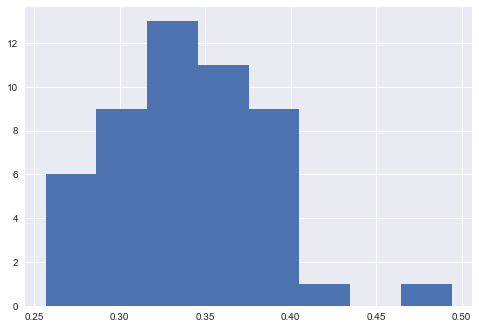

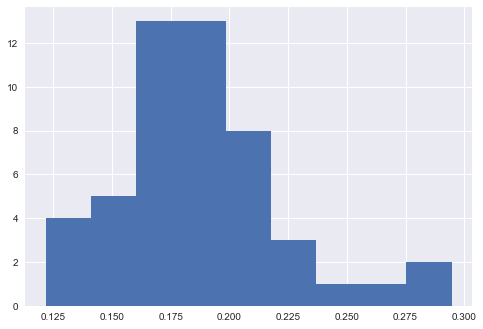

In [28]:
N_rand=50
accuracy_array=np.zeros(N_rand)

for j in range(N_rand):
    rand_index=np.random.randint(len(Y_hash), size=10)
    neigh_rand = KNeighborsClassifier(n_neighbors=1)
    neigh_rand.fit(X_test[rand_index,:], Y_test[rand_index])
    Y_pred_rand=neigh_rand.predict(X_test)
    accuracy_array[j]=sum(Y_pred_rand==Y_test)/len(Y_test)
    
plt.hist(accuracy_array, bins='auto')
plt.show()

for j in range(N_rand):
    rand_index=np.random.randint(len(Y_hash), size=10)
    neigh_rand = KNeighborsClassifier(n_neighbors=5)
    neigh_rand.fit(X_test[rand_index,:], Y_test[rand_index])
    Y_pred_rand=neigh_rand.predict(X_test)
    accuracy_array[j]=sum(Y_pred_rand==Y_test)/len(Y_test)
    
plt.hist(accuracy_array, bins='auto')
plt.show()


## Random Forest Classifiers
Let us try these experiments with more powerful classifiers such as Random Forests.

/Users/pmehta/Anaconda/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


The train accuracy is 1.0
The test accuracy is 0.8101
Accuracy 0.9317182831428855


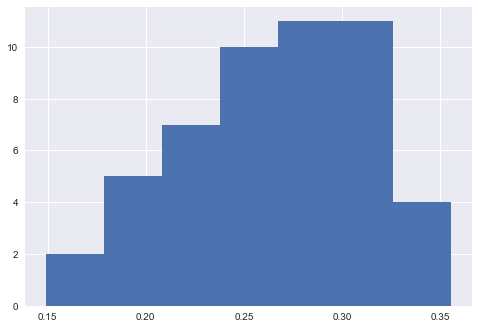

In [29]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import cross_val_score

# Check accuracy on Hash table
RFC = RandomForestClassifier(1000)
RFC.fit(X_hash, Y_hash)


# check accuracy on hash
RFC_train_accuracy=RFC.score(X_hash,Y_hash)
RFC_test_accuracy=RFC.score(X_test,Y_test)

print("The train accuracy is", RFC_train_accuracy)
print("The test accuracy is", RFC_test_accuracy)

#Check accuracy on Full data set

RFC_full = RandomForestClassifier(50)
RFC_full.fit(X_train, Y_train)

scores = cross_val_score(RFC_full, X_test, Y_test)

print ('Accuracy {0}'.format(np.mean(scores)))


N_rand=50
accuracy_array=np.zeros(N_rand)

for j in range(N_rand):
    rand_index=np.random.randint(len(Y_hash), size=10)
    RFC_rand = RandomForestClassifier(1000)
    RFC_rand.fit(X_test[rand_index,:], Y_test[rand_index])
    Y_pred_rand=RFC_rand.predict(X_test)
    accuracy_array[j]=sum(Y_pred_rand==Y_test)/len(Y_test)
    
plt.hist(accuracy_array, bins='auto')
plt.show()



In [30]:
# Gradient Boosted Trees
import xgboost as xgb
from sklearn.model_selection import GridSearchCV 


XGBclassifier = xgb.sklearn.XGBClassifier(nthread=-1, seed=1,n_estimators=1000)
#Train and time classifier
XGBclassifier.fit(X_hash, Y_hash)

#Make Predictions

#Print Results
print("Model Accuray on Train: {:.2f}%".format(100*XGBclassifier.score(X_hash, Y_hash)))

print("Model Accuray on Test: {:.2f}%".format(100*XGBclassifier.score(X_test, Y_test)))



/Users/pmehta/Anaconda/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Model Accuray on Train: 100.00%
Model Accuray on Test: 74.43%


/Users/pmehta/Anaconda/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


The train accuracy is 1.0
The test accuracy is 0.8269
[7 2 1 ... 4 8 6]


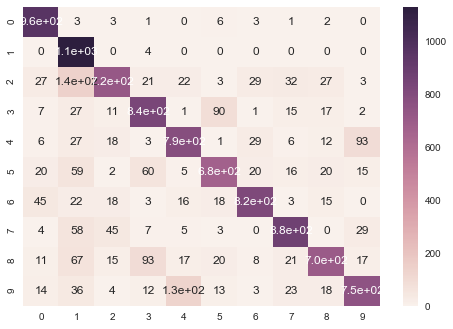

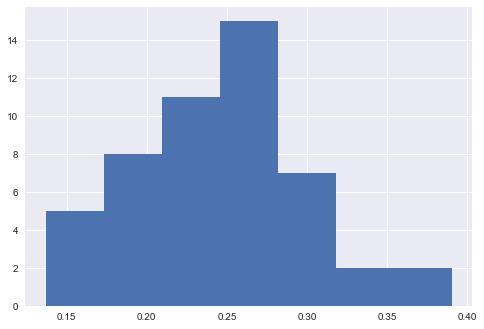

In [31]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import confusion_matrix

# Check accuracy on Hash table
RFC = ExtraTreesClassifier(1000, max_features=28, min_samples_split=5)
RFC.fit(X_hash, Y_hash)


# check accuracy on hash
RFC_train_accuracy=RFC.score(X_hash,Y_hash)
RFC_test_accuracy=RFC.score(X_test,Y_test)

print("The train accuracy is", RFC_train_accuracy)
print("The test accuracy is", RFC_test_accuracy)

print(RFC.predict(X_test))


sbn.heatmap(confusion_matrix(Y_test, RFC.predict(X_test)),annot=True)

plt.show()

N_rand=50
accuracy_array=np.zeros(N_rand)

for j in range(N_rand):
    rand_index=np.random.randint(len(Y_hash), size=10)
    RFC_rand = RandomForestClassifier(1000,max_features=28, min_samples_split=2)
    RFC_rand.fit(X_test[rand_index,:], Y_test[rand_index])
    Y_pred_rand=RFC_rand.predict(X_test)
    accuracy_array[j]=sum(Y_pred_rand==Y_test)/len(Y_test)
    
plt.hist(accuracy_array, bins='auto')
plt.show()
